In [11]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch
from keras import layers
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import metrics
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
from keras.metrics import AUC
import keras

In [12]:
# Set the path to your datasets
BASE_PATH = "C:\\kaggle\\input\\ArTaxOr"

# Step 1: Image Preprocessing
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


            labels  encoded_labels
0          Araneae               0
2418    Coleoptera               1
4528       Diptera               2
6558     Hemiptera               3
8945   Hymenoptera               4
10993  Lepidoptera               5
13099      Odonata               6


In [3]:
def img_display(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

In [4]:
class InsectDataset(Dataset):
    def __init__(self, img_data, img_path, transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        self.filenames = []  # Store filenames

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, index):
        img_name = os.path.join(self.img_path, self.img_data.loc[index, 'labels'], self.img_data.loc[index, 'Images'])
        self.filenames.append(img_name)  # Store filename
        image = Image.open(img_name)
        image = image.resize((224, 224))  # Resize images
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
            image = self.transform(image)  # Apply transformation here
        return image, label


In [5]:
class InsectDataset(Dataset):
    def __init__(self, img_data, img_path, transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, index):
        img_name = os.path.join(self.img_path, self.img_data.loc[index, 'labels'], self.img_data.loc[index, 'Images'])
        image = Image.open(img_name)
        image = image.resize((224, 224))  # Resize images
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
            image = self.transform(image)  # Apply transformation here
        return image, label

In [6]:
# Step 3: Training the Models
# Split the data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Number of classes (insects)
num_classes = len(unique_labels)

# Create data generators
train_gen = InsectDataset(train_data, BASE_PATH, transform=transform)
test_gen = InsectDataset(test_data, BASE_PATH, transform=transform)

# Define batch size
batch_size = 64   # You can adjust this based on your system's capacity

# Assuming you have train_gen and test_gen already defined as ImageDataGenerator instances
train_gen = ImageDataGenerator(rescale=(1./255.), validation_split=0.2)
test_gen = ImageDataGenerator(rescale=(1./255.))

In [7]:
# Step 2: Model Modification for Insect Classification

def get_custom_model(num_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    base_model_output = base_model.output

    # Custom Layers
    x = Conv2D(64, kernel_size=(3, 3), padding='same', strides=2, activation="relu")(base_model_output)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=1, padding='same')(x)

    x = Conv2D(32, kernel_size=(5, 5), padding='same', strides=1, activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=1, padding='same')(x)

    x = Conv2D(256, kernel_size=(2, 2), padding='same', strides=1, activation="relu")(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)

    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Adjust this part to handle variable number of classes
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model


In [8]:
# Create the InceptionV3 model
custom_model = get_custom_model(num_classes)

In [19]:
# Compile the model
from keras.models import load_model

# Compile the model
custom_model.compile(loss="categorical_crossentropy",
                      optimizer=SGD(learning_rate=0.001, momentum=0.9),
                      metrics=['accuracy', metrics.Recall(), metrics.Precision(), metrics.AUC()])

# Assuming you have train_dir and val_dir already defined
train_dir = BASE_PATH
val_dir = BASE_PATH

# Train AlexNet
history_custom = custom_model.fit(
    train_gen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical', 
                                  subset='training'),
    epochs=10,
    validation_data=train_gen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=batch_size, 
                                                  class_mode='categorical', subset='validation')
    #,callbacks=[EarlyStopping(patience=3)]
)


# Save the model
custom_model.save("C:/Deep Learning/Project/Classification Models/inceptionv3_model.h5")

# Save training history to a CSV file
history_df = pd.DataFrame(history_custom.history)
history_df.to_csv("C:/Deep Learning/Project/Classification Models/inceptionv3_history.csv", index=False)


Found 12303 images belonging to 7 classes.
Found 3073 images belonging to 7 classes.
Epoch 1/10
193/193 [==============================] - 2075s 11s/step - loss: 1.2486 - accuracy: 0.5690 - recall: 0.4614 - precision: 0.7037 - auc_1: 0.8735 - val_loss: 1.0649 - val_accuracy: 0.6437 - val_recall: 0.3977 - val_precision: 0.8760 - val_auc_1: 0.9111
Epoch 2/10
193/193 [==============================] - 2665s 14s/step - loss: 0.9664 - accuracy: 0.6569 - recall: 0.5547 - precision: 0.7729 - auc_1: 0.9223 - val_loss: 0.9315 - val_accuracy: 0.6635 - val_recall: 0.5340 - val_precision: 0.8234 - val_auc_1: 0.9264
Epoch 3/10
193/193 [==============================] - 2754s 14s/step - loss: 0.8408 - accuracy: 0.6994 - recall: 0.6094 - precision: 0.8049 - auc_1: 0.9406 - val_loss: 0.9456 - val_accuracy: 0.6739 - val_recall: 0.5880 - val_precision: 0.7870 - val_auc_1: 0.9253
Epoch 4/10
193/193 [==============================] - 2281s 12s/step - loss: 0.7310 - accuracy: 0.7352 - recall: 0.6589 - prec

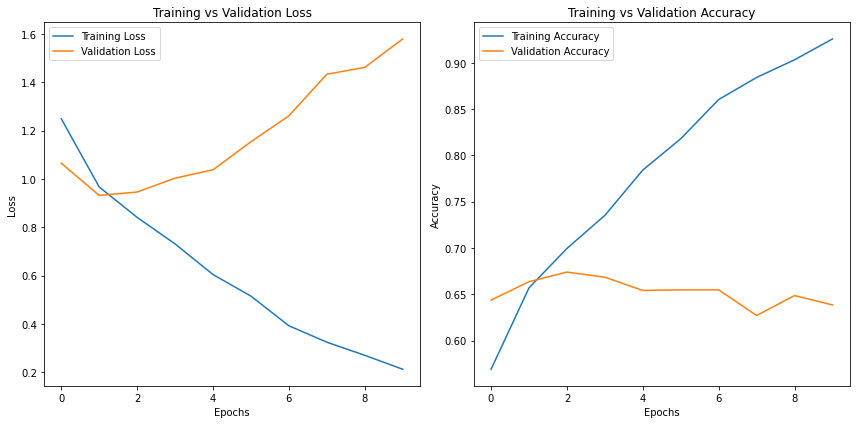

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
file_path = "C:/Deep Learning/Project/Classification Models/inceptionv3_history.csv"  # Update with the correct file path
history_data = pd.read_csv(file_path)

# Plot Training vs Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot Training vs Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_data['accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Testing Prediction on Unlabeled Images

1/1 [==============================] - 4s 4s/step


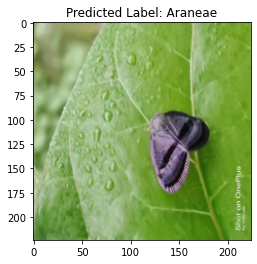

Predicted Label for the New Image: Araneae


In [9]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/inceptionv3_model.h5")


# Specify the path to the new, unlabeled image
new_image_path = "C:/DL Small Set/Hemiptera/IMG_20210928_072325.jpg"

# Load and preprocess the new image
new_image = Image.open(new_image_path)
new_image = new_image.resize((224, 224))
new_image_array = np.array(new_image) / 255.0  # Normalize pixel values
new_image_array = np.expand_dims(new_image_array, axis=0)  # Add batch dimension

# Make predictions on the new image
new_image_prediction = loaded_model.predict(new_image_array)

# Convert the prediction to a class label
predicted_label = lb.inverse_transform(new_image_prediction.argmax(axis=1))[0]

# Display the new image along with the predicted label
plt.imshow(new_image)
plt.title(f"Predicted Label: {predicted_label}")
plt.show()

print("Predicted Label for the New Image:", predicted_label)

1/1 [==============================] - 1s 1s/step


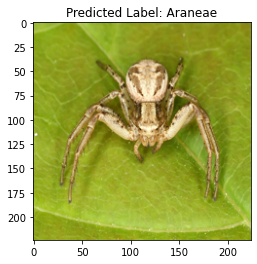

Predicted Label for the New Image: Araneae


In [23]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/inceptionv3_model.h5")

# Specify the path to the new, unlabeled image
new_image_path = "C:/kaggle/input/ArTaxOr/Araneae/fa6b4011c1f0.jpg"

# Load and preprocess the new image
new_image = Image.open(new_image_path)
new_image = new_image.resize((224, 224))
new_image_array = np.array(new_image) / 255.0  # Normalize pixel values
new_image_array = np.expand_dims(new_image_array, axis=0)  # Add batch dimension

# Make predictions on the new image
new_image_prediction = loaded_model.predict(new_image_array)

# Convert the prediction to a class label
predicted_label = lb.inverse_transform(new_image_prediction.argmax(axis=1))[0]

# Display the new image along with the predicted label
plt.imshow(new_image)
plt.title(f"Predicted Label: {predicted_label}")
plt.show()

print("Predicted Label for the New Image:", predicted_label)

In [24]:
loaded_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_191 (Conv2D)            (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_191 (Batch  (None, 111, 111, 32  96         ['conv2d_191[0][0]']             
 Normalization)                 )                                                           

# Testing Prediction on ArTaxOr

            labels  encoded_labels
0          Araneae               0
2418    Coleoptera               1
4528       Diptera               2
6558     Hemiptera               3
8945   Hymenoptera               4
10993  Lepidoptera               5
13099      Odonata               6
Found 15376 images belonging to 7 classes.
241/241 [==============================] - 1696s 7s/step - loss: 0.4759 - accuracy: 0.8690 - recall: 0.8548 - precision: 0.8875 - auc_1: 0.9777
Found 15376 images belonging to 7 classes.
1/1 [==============================] - 0s 110ms/step


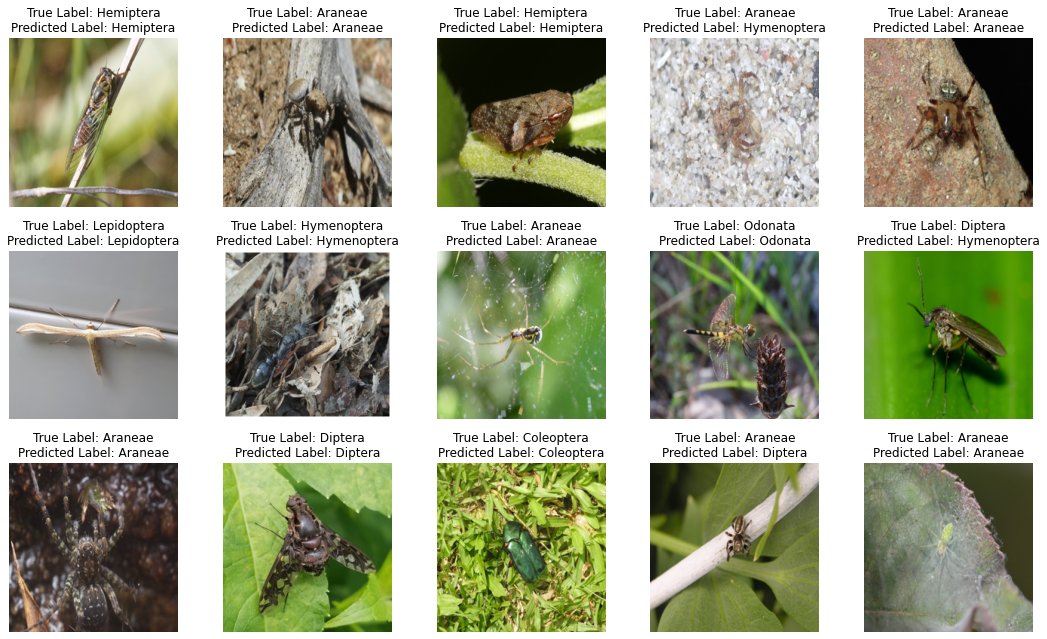

Custom Inceptionv3 Test Loss: 0.47593188285827637
Custom Inceptionv3 Test Accuracy: 0.8690166473388672


In [25]:
from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/inceptionv3_model.h5")

# Set the path to the test set
test_dir = "C:\\kaggle\input\ArTaxOr"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\kaggle\input\ArTaxOr"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels from the data dataframe
true_labels = []

# Create a list of indices and shuffle it
indices = list(range(len(data)))
np.random.shuffle(indices)

for i in range(15):  # Select 15 random images
    random_index = indices[i]
    img_name = data.iloc[random_index]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    true_labels.append(true_label)

# Convert the true labels to numpy array
true_labels = np.array(true_labels)

# Evaluate the model on the test set and make predictions
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))
predictions = loaded_model.predict(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create a 3x5 subplot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
fig.tight_layout()

# Loop over the selected random images
for i in range(len(true_labels)):
    img_name = data.iloc[indices[i]]['Images']
    img_path = os.path.join(BASE_PATH, data.iloc[indices[i]]['labels'], img_name)
    true_label = lb.inverse_transform([true_labels[i]])[0]

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)

    # Convert the prediction to a class label
    predicted_label = lb.inverse_transform(img_prediction.argmax(axis=1))[0]

    # Plot the image along with true and predicted labels
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")

# Show the plot
plt.show()


# Display the evaluation results
print("Custom Inceptionv3 Test Loss:", test_results[0])
print("Custom Inceptionv3 Test Accuracy:", test_results[1])

# Testing Prediction on Mobile Corpus

            labels  encoded_labels
0          Araneae               0
4776    Coleoptera               1
5315       Diptera               2
5892     Hemiptera               3
6580   Hymenoptera               4
7251   Lepidoptera               5
10649      Odonata               6
Found 14530 images belonging to 7 classes.
228/228 [==============================] - 4005s 18s/step - loss: 1.8323 - accuracy: 0.5863 - recall: 0.5632 - precision: 0.6194 - auc_1: 0.8560
Found 14530 images belonging to 7 classes.
1/1 [==============================] - 0s 94ms/step


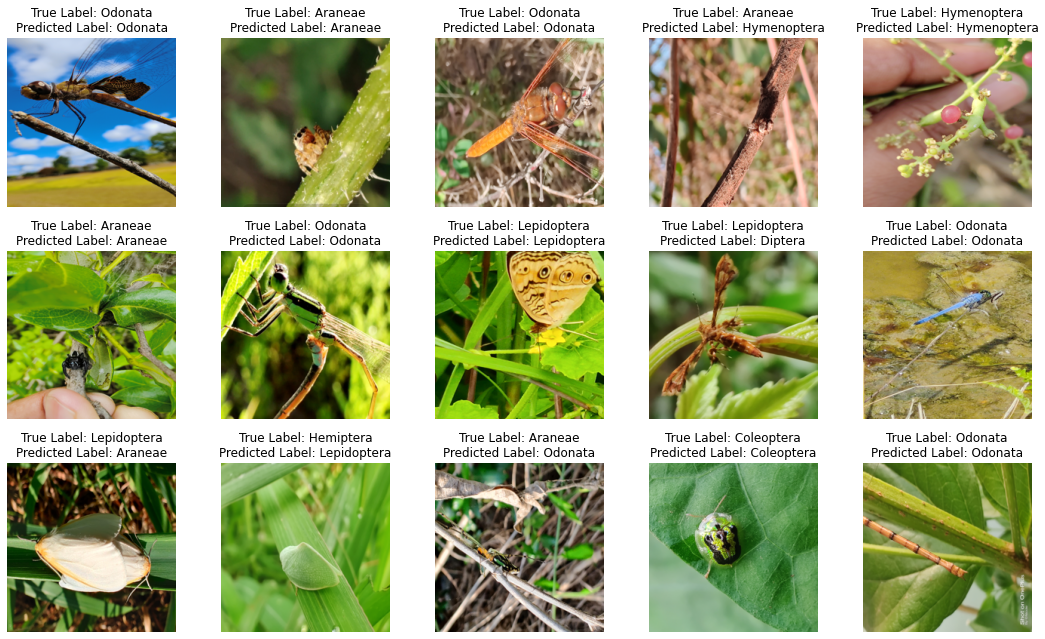

Custom Inceptionv3 Test Loss: 1.8322757482528687
Custom Inceptionv3 Test Accuracy: 0.5863041877746582


In [26]:
from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/inceptionv3_model.h5")

# Set the path to the test set
test_dir = "C:\\DL Testing Set"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Testing Set"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels from the data dataframe
true_labels = []

# Create a list of indices and shuffle it
indices = list(range(len(data)))
np.random.shuffle(indices)

for i in range(15):  # Select 15 random images
    random_index = indices[i]
    img_name = data.iloc[random_index]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    true_labels.append(true_label)

# Convert the true labels to numpy array
true_labels = np.array(true_labels)

# Evaluate the model on the test set and make predictions
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))
predictions = loaded_model.predict(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create a 3x5 subplot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
fig.tight_layout()

# Loop over the selected random images
for i in range(len(true_labels)):
    img_name = data.iloc[indices[i]]['Images']
    img_path = os.path.join(BASE_PATH, data.iloc[indices[i]]['labels'], img_name)
    true_label = lb.inverse_transform([true_labels[i]])[0]

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)

    # Convert the prediction to a class label
    predicted_label = lb.inverse_transform(img_prediction.argmax(axis=1))[0]

    # Plot the image along with true and predicted labels
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")

# Show the plot
plt.show()


# Display the evaluation results
print("Custom Inceptionv3 Test Loss:", test_results[0])
print("Custom Inceptionv3 Test Accuracy:", test_results[1])

# Testing on Small ArtaxOr_Mobile Mix

          labels  encoded_labels
0        Araneae               0
31    Coleoptera               1
66       Diptera               2
96     Hemiptera               3
130  Hymenoptera               4
164  Lepidoptera               5
196      Odonata               6
Found 229 images belonging to 7 classes.
4/4 [==============================] - 46s 10s/step - loss: 1.2007 - accuracy: 0.6812 - recall: 0.6638 - precision: 0.7136 - auc_1: 0.9278
Found 229 images belonging to 7 classes.
1/1 [==============================] - 0s 117ms/step


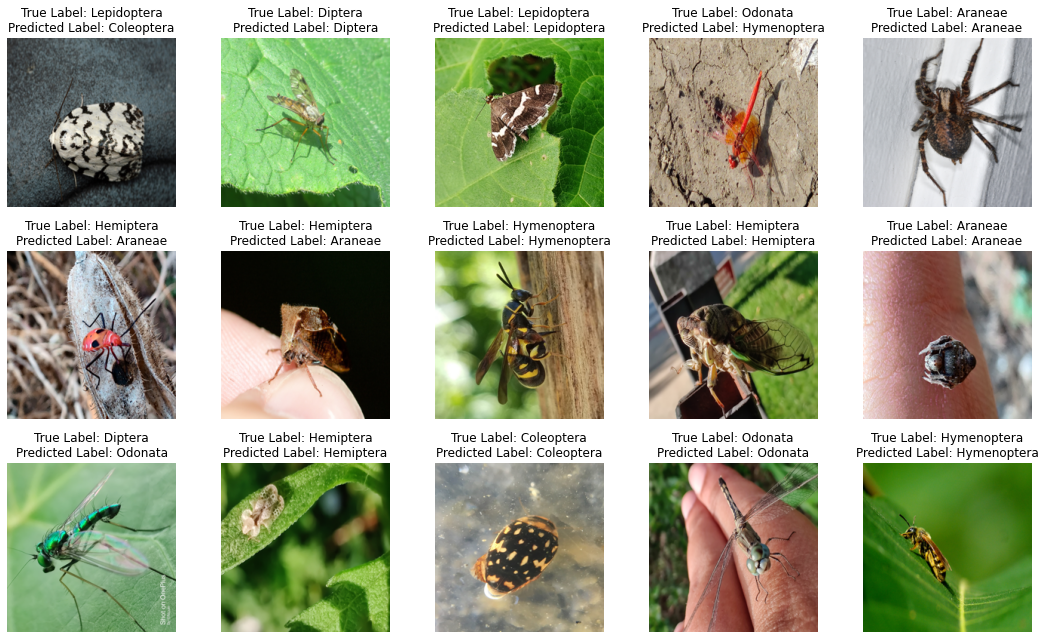

Custom Inceptionv3 Test Loss: 1.2007334232330322
Custom Inceptionv3 Test Accuracy: 0.6812227368354797


In [27]:
from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/inceptionv3_model.h5")

# Set the path to the test set
test_dir = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels from the data dataframe
true_labels = []

# Create a list of indices and shuffle it
indices = list(range(len(data)))
np.random.shuffle(indices)

for i in range(15):  # Select 15 random images
    random_index = indices[i]
    img_name = data.iloc[random_index]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    true_labels.append(true_label)

# Convert the true labels to numpy array
true_labels = np.array(true_labels)

# Evaluate the model on the test set and make predictions
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))
predictions = loaded_model.predict(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create a 3x5 subplot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
fig.tight_layout()

# Loop over the selected random images
for i in range(len(true_labels)):
    img_name = data.iloc[indices[i]]['Images']
    img_path = os.path.join(BASE_PATH, data.iloc[indices[i]]['labels'], img_name)
    true_label = lb.inverse_transform([true_labels[i]])[0]

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)

    # Convert the prediction to a class label
    predicted_label = lb.inverse_transform(img_prediction.argmax(axis=1))[0]

    # Plot the image along with true and predicted labels
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")

# Show the plot
plt.show()


# Display the evaluation results
print("Custom Inceptionv3 Test Loss:", test_results[0])
print("Custom Inceptionv3 Test Accuracy:", test_results[1])

# Confusion Matrices

## Confusion Matrix for Mobile-ArTaxOR Mix set

          labels  encoded_labels
0        Araneae               0
31    Coleoptera               1
66       Diptera               2
96     Hemiptera               3
130  Hymenoptera               4
164  Lepidoptera               5
196      Odonata               6
1/1 [==============================] - 0s 110ms/step


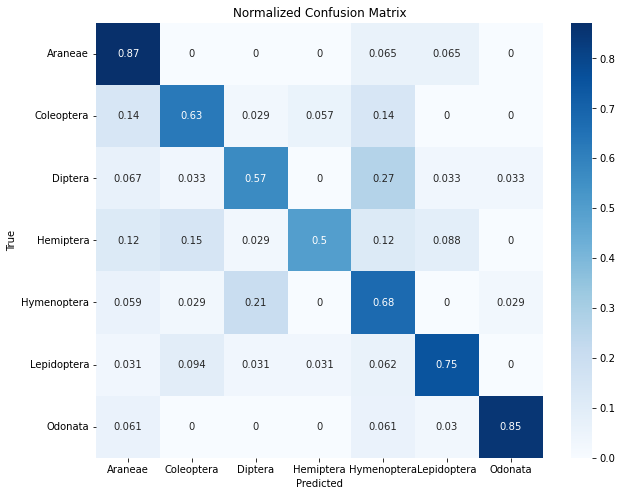

Classification Report:
              precision    recall  f1-score   support

     Araneae       0.63      0.87      0.73        31
  Coleoptera       0.69      0.63      0.66        35
     Diptera       0.63      0.57      0.60        30
   Hemiptera       0.85      0.50      0.63        34
 Hymenoptera       0.50      0.68      0.58        34
 Lepidoptera       0.77      0.75      0.76        32
     Odonata       0.93      0.85      0.89        33

    accuracy                           0.69       229
   macro avg       0.71      0.69      0.69       229
weighted avg       0.72      0.69      0.69       229



In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/inceptionv3_model.h5")

# Set the path to the test set
test_dir = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels and predictions for the entire test set
true_labels = []
predicted_labels = []

# Loop over the entire test set
for i in range(len(data)):
    img_name = data.iloc[i]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    
    # Load and preprocess the image
    img_path = os.path.join(BASE_PATH, data.iloc[i]['labels'], img_name)
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)
    predicted_label = np.argmax(img_prediction)

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create a confusion matrix for the entire test set
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap of the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=unique_labels['labels'], yticklabels=unique_labels['labels'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the classification report for the entire test set
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels['labels']))


## Confusion Matrix for Mobile Corpus

            labels  encoded_labels
0          Araneae               0
4776    Coleoptera               1
5315       Diptera               2
5892     Hemiptera               3
6580   Hymenoptera               4
7251   Lepidoptera               5
10649      Odonata               6
1/1 [==============================] - 3s 3s/step


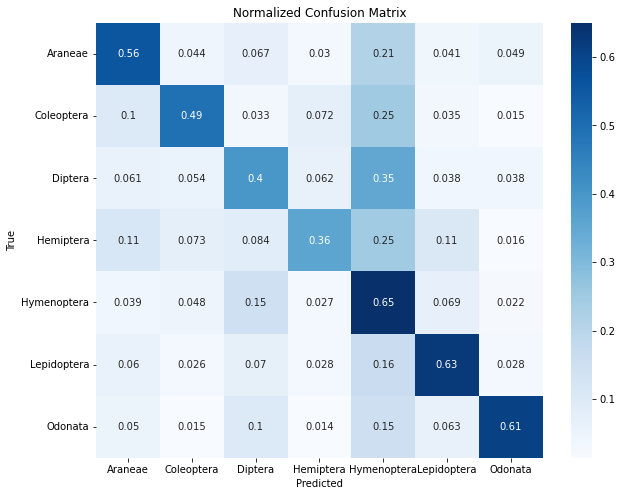

Classification Report:
              precision    recall  f1-score   support

     Araneae       0.82      0.56      0.66      4777
  Coleoptera       0.36      0.49      0.42       540
     Diptera       0.17      0.40      0.24       577
   Hemiptera       0.39      0.36      0.37       687
 Hymenoptera       0.14      0.65      0.23       671
 Lepidoptera       0.78      0.63      0.70      3398
     Odonata       0.85      0.61      0.71      3720

    accuracy                           0.57     14370
   macro avg       0.50      0.53      0.48     14370
weighted avg       0.72      0.57      0.62     14370



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/inceptionv3_model.h5")

# Set the path to the test set
test_dir = "C:\\DL Testing Set"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Testing Set"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 512

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels and predictions for the entire test set
true_labels = []
predicted_labels = []

# Loop over the entire test set
for i in range(len(data)):
    img_name = data.iloc[i]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    
    # Load and preprocess the image
    img_path = os.path.join(BASE_PATH, data.iloc[i]['labels'], img_name)
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)
    predicted_label = np.argmax(img_prediction)

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create a confusion matrix for the entire test set
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap of the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=unique_labels['labels'], yticklabels=unique_labels['labels'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the classification report for the entire test set
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels['labels']))


## Confusion Matrix for ArTaxOr

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/inceptionv3_model.h5")

# Set the path to the test set
test_dir = "C:\\kaggle\\input\\ArTaxOr"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\kaggle\\input\\ArTaxOr"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 512

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels and predictions for the entire test set
true_labels = []
predicted_labels = []

# Loop over the entire test set
for i in range(len(data)):
    img_name = data.iloc[i]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    
    # Load and preprocess the image
    img_path = os.path.join(BASE_PATH, data.iloc[i]['labels'], img_name)
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)
    predicted_label = np.argmax(img_prediction)

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create a confusion matrix for the entire test set
cm = confusion_matrix(true_labels, predicted_labels)

# Create a normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=unique_labels['labels'], 
            yticklabels=unique_labels['labels'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Alternatively, you can use the plot_confusion_matrix function
# Note: Ensure that you have scikit-learn version 0.22 or newer for this function
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(loaded_model, X_test, y_test, display_labels=unique_labels['labels'], cmap='Blues', 
                      ax=ax, normalize='true')
plt.title('Normalized Confusion Matrix')
plt.show()

# Print the classification report for the entire test set
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels['labels']))

            labels  encoded_labels
0          Araneae               0
2418    Coleoptera               1
4528       Diptera               2
6558     Hemiptera               3
8945   Hymenoptera               4
10993  Lepidoptera               5
13099      Odonata               6
1/1 [==============================] - 15s 15s/step


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications.inception_v3 import InceptionV3

def get_custom_model(num_classes):
    model = Sequential([
        # Base InceptionV3 model
        InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
        
        # Custom Layers
        Conv2D(64, kernel_size=(3, 3), padding='same', strides=2, activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),
        
        Conv2D(32, kernel_size=(5, 5), padding='same', strides=1, activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),
        
        Conv2D(256, kernel_size=(2, 2), padding='same', strides=1, activation="relu"),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(2048, activation='relu'),
        Dropout(0.5),
        
        # Output layer with softmax activation
        Dense(num_classes, activation='softmax')
    ])
    
    return model

num_classes = 7  # Replace with the actual number of classes
custinception_model = get_custom_model(num_classes)
custinception_model.summary()